# FB Prophet Modeling

This notebook attempts to recreate overall model using FB Prophet time series toolkit

In [43]:
# Standard import. Having environment issues with Plotly

import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.model_selection import ParameterGrid
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import matplotlib
import random

In [44]:
# Import util file

from util import dickey_fuller, process_neighborhood, report_metrics, plot_results

In [3]:
# Import clean dataset

df_citibike = pd.read_csv('./../clean_data/final_clean_ridership.csv', low_memory=False)

In [4]:
# Convert starttime to date and set as index

df_citibike['starttime'] = pd.to_datetime(df_citibike['starttime'])

df_citibike.set_index('starttime', inplace=True)

In [5]:
# Create the daily file

daily_ridership = df_citibike[['ride_count']].resample('1D').sum()

# Backfill dates with 0 rides (logic for this change in EDA notebook)
daily_ridership['ride_count'] = daily_ridership['ride_count'].replace(to_replace=0, method='bfill')

In [6]:
# Define Train / Test split time

test_start = '2020-11-01'

In [7]:
# Convert daily to weekly for modeling

weekly_ridership = daily_ridership.resample('W-SUN').sum()

weekly_ridership['future'] = (weekly_ridership.index >= test_start).astype('int')

# Log transform ridership

weekly_ridership['ride_count_log'] = weekly_ridership['ride_count'].apply(lambda x: np.log(x))

In [8]:
# Create train test splits

train_weekly = weekly_ridership[weekly_ridership['future'] == 0]['ride_count_log']
test_weekly = weekly_ridership[weekly_ridership['future'] == 1]['ride_count_log']

In [9]:
# Instantiate a Prophet object

m = Prophet(weekly_seasonality=True)

In [10]:
# Create DataFrame of the training data with columns needed for Prophet

train_df = train_weekly.to_frame().reset_index()

train_df.rename(columns={'starttime': 'ds', 'ride_count_log': 'y'}, inplace=True)

# Repeat for test

test_df = train_weekly.to_frame().reset_index()

test_df.rename(columns={'starttime': 'ds', 'ride_count_log': 'y'}, inplace=True)

In [11]:
# Sense check output

train_df.head()

,ds,y
0,2013-06-02,10.114275
1,2013-06-09,11.426899
2,2013-06-16,11.546264
3,2013-06-23,12.040437
4,2013-06-30,12.146275


In [12]:
# Fit on the training data

m.fit(train_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1346.39    0.00030886       125.057     0.05639           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       1346.39   3.16868e-05       110.284   2.534e-07       0.001      168  LS failed, Hessian reset 
     199       1347.78     0.0012106       84.6678        1.43           1      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1348.9    0.00068587       99.3731      0.4013      0.6274      429   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1349.47   4.25266e-06       68.6651      0.2351      0.2351      559   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     427       1349.48   0.000117295       192.466   1.254e-06       0.001      6

In [26]:
# Create "future" df

future = m.make_future_dataframe(freq='W', periods=53)
future.tail()

,ds
435,2021-10-03
436,2021-10-10
437,2021-10-17
438,2021-10-24
439,2021-10-31


In [27]:
# Store forecast in the new dataframe

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
435,2021-10-03,13.109958,12.791891,13.411953
436,2021-10-10,13.037553,12.715610,13.338367
437,2021-10-17,12.980473,12.667595,13.301003
438,2021-10-24,12.970031,12.660899,13.284335
439,2021-10-31,12.962895,12.640392,13.281061


In [36]:
preds = forecast[['ds', 'yhat']]

preds['ds'] = pd.to_datetime(preds['ds'])

preds.set_index('ds', inplace=True)

preds = preds[preds.index > '10/31/2020']

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/2576629608.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])


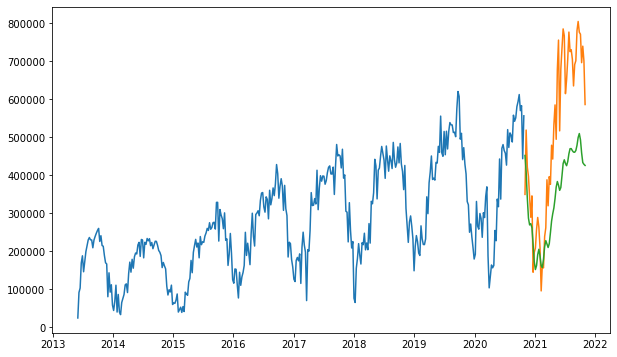

In [29]:
# Plot the predictions

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(np.exp(train_weekly))
ax.plot(np.exp(test_weekly))
ax.plot(np.exp(preds));

In [31]:
# Calculate the explained variance

ev = metrics.explained_variance_score(test_weekly, preds)
ev

0.7863453713471694

Conclusions: the COVID downturn is messing with the predictions. Let's see if we can't add in controls for this.

Explained variances is 79%, which actually isn't bad, but we know that we can get that up to 83%.

## Grid Search

In [39]:
# Define range of the grid search (using an example from Kaggle in the link below)
# https://www.kaggle.com/manovirat/timeseries-using-prophet-hyperparameter-tuning

params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale': [0.1,0.2,0.3,0.4,0.5],
               'holidays_prior_scale': [0.1,0.2,0.3,0.4,0.5],
               'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)

In [40]:
# Create a dataframe to store the EV from each run of the grid search

grid_search_results = pd.DataFrame(columns = ['EV','Parameters'])

grid_search_results['Parameters'] = grid

In [45]:
for i, p in enumerate(grid):
    random.seed(0)
    gs_model = Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                       holidays_prior_scale = p['holidays_prior_scale'],
                       n_changepoints = p['n_changepoints'],
                       seasonality_mode = p['seasonality_mode'],
                       yearly_seasonality = True,
                       interval_width=0.95)
    # Fit the model
    gs_model.add_country_holidays(country_name='US')
    gs_model.fit(train_df)
    
    # Create a dataframe to store the predictions
    future = m.make_future_dataframe(freq='W', periods=53)
    
    # Store forecast in the new dataframe
    forecast = gs_model.predict(future)
    
    # Slice on only the relevant predictions
    preds = forecast[['ds', 'yhat']]
    preds['ds'] = pd.to_datetime(preds['ds'])
    preds.set_index('ds', inplace=True)
    preds = preds[preds.index > '10/31/2020']
    
    # Calculate EV score
    ev = metrics.explained_variance_score(test_weekly, preds)
    
    # Store the results in our dataframe
    grid_search_results.loc[i,'EV'] = ev

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1350.98    0.00200201       192.545           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1354.01    0.00197607       194.205           1           1      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1355.24    0.00103392       128.693           1           1      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1355.44   5.94295e-05       73.1025           1           1      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1355.6    0.00472303       160.059           1           1      583   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1357.82    0.00139023       290.631           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1360.24   0.000428388       172.482      0.7278      0.7278      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1361.15   0.000339174       282.252           1           1      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     366       1361.29   1.59369e-05       88.1204   8.752e-08       0.001      482  LS failed, Hessian reset 
     399       1361.37    5.0074e-06       65.5893      0.2964      0.2964      522   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1361.51   0.000553059     

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1350.34    0.00484077       534.262           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1353.72    0.00304447       594.473           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1354.91   0.000251679        455.04      0.1411           1      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1355.54   9.64873e-05        103.47           1           1      488   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1355.73   0.000260491       98.6547       4.391      0.4391      604   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1357.14    0.00206709       400.773      0.2827      0.5779      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199          1360    0.00239255       711.032           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1360.87   0.000415176       471.913           1           1      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1361.43    0.00163872       120.244           1           1      481   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1361.99   0.000216625       96.1089           1           1      605   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1349.92    0.00144991       708.624           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1354.06   0.000512291       206.885      0.2473      0.6539      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1355.04   7.14445e-05       510.652      0.4114      0.4114      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1355.57   8.93832e-05        108.96           1           1      476   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1355.92   0.000421934       110.822           1           1      587   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1356.69   0.000859227       666.495           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1360.1   0.000231167        369.04      0.4716      0.4716      263   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1360.81   0.000370662       182.229           1           1      377   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1361.23   3.89834e-05       115.997           1           1      486   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1361.84   2.19243e-05       303.466      0.2342      0.2342      602   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1350.53   0.000513466       354.375      0.4997      0.4997      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1353.83    0.00121503        88.207           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1355.17    0.00118027        116.28           1           1      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1355.46   2.70806e-05       73.4514      0.7123      0.7123      483   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1355.93   0.000662964       85.8538      0.5341           1      602   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1356.52    0.00240345       678.924      0.3367           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1359.8   0.000571419       70.0096      0.1151      0.7375      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1360.96   0.000192209       196.928           1           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1361.3   0.000108179       96.3099           1           1      476   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1361.9   0.000176539       99.6391       0.463       0.463      594   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1350.95    0.00113427       206.644           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1353.61   0.000321714       252.177      0.4934      0.4934      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1354.93     0.0010173       161.333           1           1      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1355.51    0.00032218       83.9318      0.2394           1      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1355.73    0.00125343       119.978           1           1      582   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1356.57    0.00247042       289.953           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1359.62   0.000473324       799.649      0.2003           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1360.84   0.000486649        237.48           1           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1361.39    0.00151236       98.7664           1           1      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1362.08   0.000105566       206.971       0.536       0.536      578   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1350.22    0.00602299       642.905       3.977      0.3977      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1353.53   0.000941752       589.671       4.219      0.4219      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1354.86   0.000680111       534.976           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1355.3   0.000345214       162.084      0.2456           1      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1355.79    0.00035874       438.586           1           1      595   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1356.81     0.0018443       181.141      0.9736      0.9736      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1359.87   0.000288648       199.057      0.6769      0.6769      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1360.79   0.000752789       216.486           1           1      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1361.23   4.94701e-05       185.587      0.5053      0.5053      485   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1361.7   0.000267491        134.15           1           1      602   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1351.86    0.00312628       153.087      0.6926      0.6926      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1354.12    0.00136766       126.449           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1355.3    0.00163929       88.6829           1           1      378   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1355.84    0.00033388       339.507           1           1      497   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1355.95   0.000221556       88.5272           1           1      613   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1356.84     0.0153096        1370.9           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1359.83   0.000875201       211.713           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1360.68    0.00751348       141.581           1           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1361.23   0.000295457       82.1641      0.7314      0.7314      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1361.44   0.000588437       73.7307           1           1      592   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1351.37   0.000741369       391.683           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1353.95   0.000368893       204.861           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1354.94   0.000301283       155.451           1           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1355.45    9.4252e-05       97.8215           1           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1355.74    0.00131884       153.696           1           1      580   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1357.56      0.001418       432.476      0.4341           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1359.75    0.00622626       583.633           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1360.52    0.00015036       182.529       0.877       0.877      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1361.31    6.6671e-05       84.4809           1           1      480   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1361.52   0.000343108         118.3           1           1      588   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1350.02    0.00197134       1031.63           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1353.9    0.00231831       314.181           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1354.93   8.15374e-05       191.383      0.4692      0.4692      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1355.35   0.000940209       147.494           1           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1355.92   4.38705e-05       103.946           1           1      581   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1355.66    0.00179432       331.927           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1359.73    0.00093118       307.131           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1360.95   0.000118348       117.469           1           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1361.29   6.31043e-05       192.664      0.4534           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1361.54    0.00253635       164.938           1           1      578   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1350.74    0.00535237         207.9       2.443      0.2443      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1353.59    0.00217248       110.454           1           1      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1354.89    0.00289503       183.971           1           1      366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1355.42   0.000913219       103.015           1           1      481   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499          1356   0.000279576       90.3533           1           1      590   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1357.11    0.00473837       452.033      0.9447      0.9447      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1359.86   0.000636277       202.183      0.2993      0.2993      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1361.1   0.000285704       100.356      0.7619      0.7619      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1361.61    0.00051126       97.1486           1           1      482   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1361.9   0.000340998       105.758           1           1      601   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1350.92   0.000900704        277.51           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1353.91    0.00035758       138.279           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1354.87   0.000169074       102.714           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1355.41   4.76754e-05        98.427       0.954       0.954      466   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1355.55   0.000263491       87.0077           1           1      579   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1355.69    0.00338845       564.759      0.1531           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1360.1    0.00146779       528.498      0.3158           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1361.16   0.000157967       230.155      0.6461      0.6461      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1361.72   0.000170384       183.517      0.5335      0.5335      481   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1361.99     0.0028536       146.721           1           1      590   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1349.69    0.00385359       183.002           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1353.48   0.000638925       190.142      0.9788      0.9788      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1354.66   0.000229621       123.429      0.8875      0.8875      361   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1355.38   0.000515361       209.957           1           1      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1355.88   2.78325e-05       122.926      0.7044      0.7044      585   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1357.65    0.00420384       1561.89           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1359.87   0.000440869       223.388           1           1      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1360.75    0.00125262       317.714           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1361.51   0.000390016       118.689      0.3445           1      493   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1361.93   4.76856e-05       107.366           1           1      604   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1351.61    0.00680066       267.845           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1354.21    0.00126152       128.129           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1355.35    0.00147844       285.131           1           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1355.77    0.00185863       148.408      0.3308           1      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1356.01   0.000517068        87.013           1           1      581   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1357.3    0.00186196       186.719      0.8459      0.8459      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1359.87   0.000588546        492.94           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1361.1    0.00197716       175.902           1           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1361.82   0.000297325       341.627           1           1      472   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1362.12   6.46841e-06       65.2544      0.2952      0.2952      588   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1350.55    0.00228778       351.774      0.6518      0.6518      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1353.94    0.00241904       333.477           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1354.88   0.000334801       154.212      0.7341      0.7341      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1355.39   3.08715e-05       101.047      0.9665      0.9665      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1355.7   0.000553731       280.569           1           1      580   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1357.37    0.00242822       205.247           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1359.78   0.000146414       205.823      0.6213      0.6213      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1360.82   0.000295292       105.031           1           1      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1361.34   7.68126e-05         93.05           1           1      482   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1361.73   0.000401023       114.997      0.6526      0.6526      590   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1349.76   0.000643592        294.49           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1353.66    0.00229433       396.948           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1354.92   0.000177432       174.294      0.1339           1      361   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1355.46   0.000349357       162.668           1           1      480   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1355.93   0.000151126       135.403           1           1      595   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1354.93    0.00237266       612.323           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1359.64    0.00191216           595       4.144      0.4144      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1360.8   0.000630831       550.471      0.3891           1      366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1361.11   0.000690683       114.768           1           1      477   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1361.79   0.000211925       118.965           1           1      593   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1359.93    0.00126487       194.331           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1363.06    0.00225935       107.082           1           1      260   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1364.61   0.000240569       96.5041           1           1      382   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1365.8    0.00121911        107.97           1           1      497   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1366.65   0.000435293       256.474           1           1      618   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1364.96    0.00077226        137.44           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1368.57     0.0022683        227.85           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1369.92    0.00133526        145.12      0.6674      0.6674      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1370.79   0.000922939       80.2355           1           1      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1371.65   0.000953798       111.571           1           1      617   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1357.83    0.00360526       360.305      0.3342           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1362.26    0.00214507       438.707           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1364.19   0.000346216        50.178           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1364.92    0.00173594        70.122           1           1      491   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1366.05   0.000171343       169.015       0.309       0.309      618   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1363.26     0.0051722       199.664           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1368.29   0.000662824        406.92      0.2733      0.2733      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1369.99   0.000145293       146.884      0.1054           1      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1370.85   0.000359475       349.369      0.3545           1      490   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1371.69   0.000121143       66.3863        0.36        0.36      611   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1355.28   0.000423552       531.121      0.9085      0.9085      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1362.02    0.00063002       326.346           1           1      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1363.28   0.000866755       228.884           1           1      374   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1364.37   0.000341726       94.6857           1           1      507   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1365.22    0.00129916       151.775           1           1      627   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1361.36    0.00195061       624.651      0.1749           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1368.39    0.00112356       251.866           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1369.86    0.00661752       533.012           1           1      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1370.53   0.000623293       58.9609      0.4186           1      484   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1371.09   0.000152426       158.224      0.7743     0.07743      600   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1357.32    0.00662866       1184.64     0.06756           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1362.22    0.00391854       525.702           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1364.07    0.00124925       193.311           1           1      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1365.38    0.00106882       107.874      0.0605      0.5459      505   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1366.43   0.000874138        85.977           1           1      634   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1362.04    0.00195677       163.821           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1368.29     0.0039845       348.585      0.4073           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1369.7   0.000698025       353.278           1           1      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1370.63    0.00124386       154.774       0.782       0.782      491   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1371.95    0.00230006       106.432           1           1      616   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1356.09    0.00260933       304.938           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1362.98     0.0164045       403.539           1           1      264   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1364.38    0.00188794       241.065           1           1      391   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1365.26    0.00131923       182.511      0.9267     0.09267      517   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1366.07   0.000635987        88.624           1           1      637   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1362.24    0.00271314       451.321           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1367.82   0.000228347       387.543      0.3285      0.3285      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1369.21    0.00036588       189.229           1           1      366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1370.1    0.00046582       99.8998           1           1      495   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1371.04    0.00060454        96.767      0.6834      0.6834      616   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1355.65    0.00567182       589.511           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1361.89    0.00134941       130.723           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1363.75     0.0011762       240.007           1           1      374   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1365.08   0.000744628       68.8596      0.1519           1      497   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1365.93   0.000324709       103.428           1           1      616   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1365.01   0.000724475       260.069           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1368.04    0.00320807       1071.34           1           1      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1369.68   0.000413375       136.468           1           1      383   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1370.63    0.00108798       143.222           1           1      508   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1371.05   0.000176201         147.3      0.6786      0.6786      624   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1355.38    0.00123757       784.242      0.5794      0.5794      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1361.71    0.00116148       113.726           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1364.19   0.000280242       318.079      0.8093      0.8093      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1365.24    0.00221999       471.939      0.8334      0.8334      469   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1366.5   0.000166033       170.649      0.3621      0.3621      593   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1361.51   0.000771935        412.14           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1367.82    0.00319746       497.677      0.6183      0.6183      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1369.38    0.00381759       114.302           1           1      361   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1370.55    0.00458284       293.866           1           1      482   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1371.29   0.000277107       54.7725       0.548       0.548      615   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1355.68    0.00768219        1537.6           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1361.86     0.0012326       169.063           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1363.48    0.00138797       116.504           1           1      375   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1364.37     0.0013677       82.3228           1           1      491   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1365.76    0.00253092       74.5593           1           1      612   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1362.04   0.000732279       504.593      0.2569           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1368.67   0.000882768        162.46      0.9384      0.9384      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1369.81   0.000509629       96.2771           1           1      374   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1370.5   0.000334304       207.823           1           1      493   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1371.07   0.000247931       109.933      0.7507      0.7507      610   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1358.48    0.00837712       1270.33           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1362.21   0.000629052       211.978       0.524       0.524      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1363.72   4.51111e-05       132.112      0.1219      0.1219      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1364.47   0.000590927       60.4169      0.7381      0.7381      491   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1365.06   0.000210267       251.888           1           1      612   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1361.36    0.00164993        428.36           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1367.1    0.00182318       132.034           1           1      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1369.07   0.000360962       315.955       0.132           1      378   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1370.05    0.00139466       290.325           1           1      495   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1370.68    0.00546348       166.572           1           1      612   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1357.35    0.00147712       1001.05           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1362.58    0.00123429       337.116           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1364.55    0.00311611       62.1427           1           1      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1365.82    0.00168766       115.534      0.8353      0.8353      495   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1367.47    0.00213981       144.266      0.5583     0.05583      619   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1363.04    0.00471031       247.625      0.8361     0.08361      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1368.39    0.00177346        151.29           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1369.68   0.000636923        80.917      0.7531      0.7531      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1370.81   0.000439703       158.783           1           1      492   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1371.52   0.000786651       149.217           1           1      607   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1356.7    0.00294424       1261.97      0.6775      0.6775      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1361.97    0.00253268       611.573           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1363.94   0.000704389       95.9351           1           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1364.72   9.98135e-05        49.915           1           1      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1365.49   0.000812207       101.987        0.93       0.093      603   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1362.9     0.0147075       653.412           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1367.91   0.000515094       489.372      0.1025           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1369.61   0.000283326       147.059      0.1354      0.1354      379   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1370.79    4.5024e-05       78.5907      0.1468      0.1468      511   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1371.25    0.00194657       86.4962           1           1      630   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1357.84    0.00556963       776.721           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1362.22   0.000327559       427.009      0.2459      0.2459      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1363.79   0.000336572       241.932      0.9914      0.9914      387   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1364.75   0.000278137       127.631           1           1      504   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1365.88    0.00154237       112.197        2.57       0.257      634   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1362.07    0.00223936       570.016           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1367.64    0.00204865       108.095           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1369.27    0.00136853       1018.27      0.3119           1      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1369.87   0.000116451       93.7881      0.6782      0.6782      484   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1370.79    0.00168302       227.705           1           1      608   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1356.2    0.00533912       521.978           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1362.02    0.00100736        184.75           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1363.93    0.00223499       113.808           1           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1364.81     0.0005507       129.139           1           1      486   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     490       1365.55   1.17325e-05       77.1188   1.087e-07       0.001      646  LS failed, Hessian reset 
     499        1365.9   0.000600531     

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1361.97    0.00260475       459.875      0.3328      0.3328      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1368.25    0.00844314       253.966           1           1      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1369.73   0.000550622       79.5167       0.836       0.836      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1370.71   0.000528185        169.23           1           1      484   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1371.62     0.0121374       165.732      0.1463      0.4533      601   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1358.83    0.00168392       583.904           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1362.9    0.00208957       661.465      0.4242           1      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1363.98    0.00537482       249.556           1           1      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1365.12    0.00345181       278.324           1           1      484   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1366.03    0.00339608       140.606           1           1      599   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1364.9    0.00448187       438.914           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1368.52   0.000735152         298.6      0.8188      0.8188      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1369.93   0.000573114       352.669      0.4552      0.4552      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1370.97    0.00020244       83.8583           1           1      493   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1371.62     0.0001955       174.053      0.5711      0.5711      610   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1353.41    0.00258684       468.967           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1361.99     0.0015384       480.551      0.2675           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1363.77    0.00208017       595.174           1           1      366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1364.74   9.26609e-05       131.981           1           1      489   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1365.37    0.00457716       169.694       9.517      0.9517      614   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1363.18   0.000332039       429.867           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1367.75   0.000303825        308.86      0.9147      0.9147      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1369.31   0.000377265       259.695      0.2516           1      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1370.22   0.000773219       74.9969           1           1      486   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1371.04   0.000514136       241.217      0.3083      0.3083      606   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1359.65    0.00486872       1037.34           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1366.21    0.00226293       174.449           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1368.79    0.00703233       235.708      0.3867           1      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1372.28    0.00204705       366.807      0.4616      0.4616      482   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1374.24    0.00228712       475.352      0.2547           1      604   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1366.45    0.00937634       585.747      0.4256      0.4256      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1372.5    0.00128478       212.406      0.2704           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1373.9    0.00143793       159.392           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1375.57    0.00101082       71.4474           1           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1377.46   0.000884882       166.539      0.3595      0.3595      584   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1360.6     0.0145181       1621.58           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1366.79    0.00133292       139.989           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1369.97    0.00192464        204.25      0.6076      0.6076      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1372.46      0.016847       285.424           1           1      480   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1374.22    0.00695024       224.047           1           1      595   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1368.22    0.00823943       417.646      0.8696      0.8696      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1372.46    0.00388739       133.448      0.6969      0.6969      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1374.47    0.00284223        173.43           1           1      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1376.34    0.00176266       166.103           1           1      477   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1377.6   0.000837048       254.205           1           1      593   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1357.95    0.00859526       778.572           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1365.77    0.00771333        235.59       1.044      0.1044      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1367.55   0.000335115       160.436           1           1      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1369.79   0.000488189       315.423           1           1      496   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1372.14     0.0140244       208.777           1           1      623   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1364.38     0.0034997       1119.48           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1370.02   0.000763765       159.708     0.06608           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1373.49    0.00371109       288.996           1           1      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1376.1    0.00122483       251.909           1           1      491   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1376.99    0.00152199       148.317      0.7461      0.7461      614   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1360.55    0.00524455       517.115           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1367.16    0.00891406       291.082           1           1      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1370.03    0.00422068       516.635           1           1      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1371.85    0.00139252       140.813      0.1478      0.8101      490   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499          1373    0.00584032       207.195           1           1      606   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1364.57     0.0022379       309.023           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1372.51    0.00105414       138.682           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1374.49     0.0027459       388.087           1           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1377.07     0.0168266       234.555       1.493      0.1493      484   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1379.64     0.0121972       351.941           1           1      593   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1357.86    0.00488358       512.809           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1365.09    0.00204791       490.443           1           1      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1367.44     0.0103526       293.779           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1370.21   0.000120244       289.833      0.1766      0.1766      492   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1371.7    0.00233184       240.049           1           1      610   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1363.77    0.00672305       553.286           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1371.56      0.006769       166.444           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1375.19    0.00575251       103.643           1           1      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1376.78    0.00216428       154.077      0.6762      0.6762      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1378.46    0.00177424        332.46          10           1      590   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1359.7     0.0049133       1069.95      0.2256           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1366.38    0.00105444       564.045      0.2174      0.2174      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1368.49    0.00105102        368.05           1           1      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1370.79   0.000986679       226.888       0.416           1      488   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1371.63    0.00150657       64.2602           1           1      618   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1365.84    0.00240621       729.496     0.03466           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1371.34   0.000824406       259.533           1           1      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1373.67   0.000373913       249.777      0.9467     0.09467      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1375.46   0.000276242       173.901           1           1      489   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1376.89   0.000641308       126.651           1           1      611   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1362.81    0.00562611       1082.26           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1368.25    0.00336343       692.349      0.0642      0.9526      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1371.86     0.0141831       367.646      0.5326     0.05326      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1374.33    0.00158937       97.8048           1           1      478   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1376.7   0.000792444       159.459           1           1      599   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1367.62    0.00918402       627.792           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1372.28    0.00392502       588.297           1           1      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1375.92     0.0065642       174.808           1           1      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1377.47    0.00123876       173.761           1           1      496   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1380.68     0.0103037       292.897           1           1      616   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1358.45    0.00178007       751.248       0.993       0.993      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1366.26   0.000436554       164.083           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1368.95    0.00253423        649.03      0.2121           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1371.43    0.00753907       50.7007           1           1      466   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1373.79    0.00199901       154.995           1           1      586   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1365.91    0.00752876       392.655           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1371.07    0.00472946       716.835           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1373.68   0.000298138       212.386      0.2433      0.2433      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1374.98   0.000110459       158.371      0.3663      0.3663      480   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1377.12    0.00168384       264.836      0.6493      0.6493      593   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1363.82     0.0235304       368.996           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1367.17    0.00318585       866.967           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1369.19   0.000623915       158.703           1           1      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1372.24     0.0126728        732.88     0.06495      0.7459      484   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1374.16    0.00161317       388.918           1           1      591   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1367.95    0.00401819       341.762           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1371.48     0.0026364       336.035           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1373.53    0.00976517       128.926           1           1      366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1376.1   0.000295108       309.713           1           1      484   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1377.04   0.000114696       79.8653      0.3302      0.3302      600   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1362.14    0.00392813       162.944      0.4324      0.9681      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1366.75     0.0150395       438.428           1           1      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1368.41    0.00223225       328.864       0.496           1      375   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1372.03   0.000459588       327.656       0.578       0.578      492   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1375.06     0.0101613       59.2207           1           1      612   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1365.53    0.00172176       838.317      0.8549      0.8549      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1372.36   0.000529297       238.063      0.2803           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1374.24    0.00389718       169.363           1           1      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1376.62    0.00530957         126.2           1           1      485   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1378.53     0.0030003       999.077           1           1      601   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1358.23    0.00309596       256.207           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1366.42   0.000944161       124.571           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1368.82   0.000765013       179.163           1           1      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1370.27    0.00384333       91.8887           1           1      492   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1372.55    0.00255794       437.742      0.7665     0.07665      610   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1364.49    0.00593373       949.454           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1371.7    0.00272359       294.702           1           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1373.95    0.00956882       182.552      0.4662           1      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1377.07    0.00517693       163.344           1           1      494   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1379.49     0.0228302       151.222           1           1      622   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1358.81    0.00163909       645.385           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1367.12    0.00239902        735.06      0.5489      0.5489      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1369.28    0.00113171       163.297           1           1      376   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1371.44    0.00985143       266.219           1           1      494   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1373.46    0.00132194       757.755      0.1595      0.1595      610   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1368.6   0.000876744       546.691     0.09063           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1373.01   0.000588502       89.5784           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1375.38   0.000367165       74.4176     0.03688           1      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1376.4    0.00208226       151.635           1           1      497   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1377.47    0.00177229       562.932      0.8138      0.8138      613   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1357.47    0.00207782       319.898      0.4298           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1366.46    0.00254843       568.848           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1368.77    0.00278221       87.9909      0.4251           1      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1371.48    0.00370187         233.9      0.6738      0.6738      488   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1374.67   0.000381082       273.061     0.04001           1      605   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1365.08    0.00124218       625.953      0.8672      0.8672      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1371.79    0.00323122       372.989      0.4667     0.04667      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1375.46   0.000130674       73.1937      0.3357      0.3357      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1377.12     0.0113906       134.044           1           1      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1380.53    0.00127334       94.5736           1           1      594   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1360.43     0.0321821       464.594           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1367.64    0.00545833       283.692       1.006      0.1006      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1369.65    0.00973875       631.679           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1372.75   0.000210338       235.351           1           1      483   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1375.38     0.0021269        168.88       1.177      0.1177      610   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1365.05    0.00364008        1036.1      0.4352           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1371.69   0.000434758        424.34           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1373.71    0.00471631       355.788      0.9243      0.9243      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1376.04   0.000625615       206.771      0.6019     0.06019      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1378.2    0.00304971       381.352      0.2612      0.2612      600   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1358.38    0.00122272       565.353      0.6845      0.6845      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1364.62   0.000783541        203.38           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1367.83    0.00536381       212.178           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1369.78    0.00234907       357.592           1           1      491   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1371.17    0.00725513       1337.94           1           1      605   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1362.78    0.00306106       450.722           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1370.92    0.00289701       319.019      0.1337           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1373.5   9.78408e-05       62.8011      0.1786      0.1786      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1375.07    0.00314415       195.016           1           1      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1377.15   0.000523498       127.251           1           1      599   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1358.72    0.00157824       957.209      0.2823      0.2823      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1368.15    0.00643675         385.9           1           1      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1371.21     0.0501744       1763.45           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1377.03    0.00375023       68.6396           1           1      483   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1378.73   0.000498083        54.724      0.8543      0.8543      598   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1367.12     0.0591506       1026.43           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1374.88    0.00706765       132.705           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1378.62    0.00218323       135.268           1           1      374   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1379.98   0.000906534       127.766           1           1      490   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1382.37    0.00993121       111.802           1           1      606   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1360.99     0.0063439       330.784           1           1      145   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1368.96    0.00235836        472.24           1           1      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1372.43     0.0014604       82.0311           1           1      378   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1377.28     0.0191918       448.855           1           1      493   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1380.24   0.000308152       157.364           1           1      615   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1364.79    0.00512398       456.905           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1373.41    0.00132199        683.92           1           1      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1377.62    0.00451422       144.238           1           1      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1378.69   0.000902454       217.396      0.2392           1      492   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1382.18   0.000317517       169.162       0.399       0.399      606   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1359.94     0.0111662       608.614           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1368.7     0.0023542       171.424           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1369.85   3.84435e-05       145.136      0.1928      0.1928      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1375.42     0.0221064       413.488           1           1      478   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1377.26   0.000290151       205.508      0.4581      0.4581      608   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1364.9   0.000987044       598.088      0.8404      0.8404      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1372.09    0.00103506       227.674           1           1      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1376.36    0.00114333       248.555      0.8412      0.8412      379   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1379.98     0.0060804       143.312      0.9578      0.9578      501   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1383.65    0.00626996       635.145           1           1      630   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1360.98    0.00612935       276.577           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1368.64    0.00040103       214.514       0.196           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1373.52     0.0020395       190.844           1           1      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1378.34    0.00425431        456.71      0.2066           1      482   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1381.34   0.000205284       69.6505           1           1      598   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1366.67    0.00705639       927.992           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1374.32    0.00275615        163.42           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1378.86   0.000998074       335.174           1           1      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1381.32     0.0122919       230.072       1.505      0.1505      499   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1383.76    0.00040822       108.429      0.4898      0.4898      608   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1360.33    0.00214794       350.951           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1369.76    0.00168117       606.154      0.6845      0.6845      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1372.58    0.00166314       568.307      0.5346      0.5346      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1375.22    0.00400137       363.896           1           1      497   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1378.19    0.00207669       416.043           1           1      613   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1365.11    0.00842097       750.998           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1374.22    0.00199632       118.938           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1377.89   0.000835179       190.245           1           1      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1381.33     0.0271426       1043.54           1           1      481   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1383.41   0.000347845        745.64      0.3899      0.3899      598   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1360.55    0.00245324         843.6           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1368.31    0.00978848       126.426           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1371.82   0.000381611       532.968           1           1      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1374.6    0.00441794        393.31           1           1      497   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1375.51   9.76861e-05       313.814      0.3542      0.3542      617   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1364.82   0.000717891       298.027           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1372.89   0.000543144       301.484           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1375.51    0.00288426       200.743      0.1961           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1377.76    0.00277865        833.48           1           1      478   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1381.2    0.00987764       233.367           1           1      600   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1361.71    0.00378085       880.933           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1368.8   0.000290368       184.069           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1371.36    0.00144246       122.917      0.6415      0.6415      376   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1376.21    0.00547341       295.781           1           1      494   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1378.32     0.0382072       113.821           1           1      613   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1364.83    0.00476887       600.823       1.557      0.1557      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1374.22   0.000646238       118.469      0.6445      0.6445      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1378.6     0.0364736       1795.95           1           1      361   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1381.32    0.00108201       180.124      0.9929      0.9929      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1383.71   0.000256568       120.239      0.4639           1      595   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1363.42     0.0109742       325.649      0.4067           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1368.39     0.0100698       251.605           1           1      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1372.65    0.00025516       247.791      0.1738      0.1738      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1376.71   0.000663062       129.454           1           1      494   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1377.92    0.00665745       1008.53           1           1      615   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1367.71    0.00013404       374.898      0.3338      0.3338      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1373.34    0.00242178       1013.31           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1377.67     0.0162872       605.637           1           1      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1381.24   0.000506032       163.886           1           1      481   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1384.7    0.00620064       157.572           1           1      599   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1360.43    0.00388814       1918.21           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1368.53   0.000312525       220.347           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1372.59   0.000827882       397.301           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1377.17    0.00785172       281.259           1           1      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1379.37     0.0166473       557.401           1           1      594   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1369.32     0.0132653       487.665      0.5112           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1375.47    0.00478904       301.747           1           1      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1378.2    0.00225826       761.687           1           1      376   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1379.57    0.00749324       303.649           1           1      494   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1382.94    0.00221637       215.193           1           1      620   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1361.29     0.0216252       2223.66     0.08885           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1368.15    0.00132093       237.899           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1371.98   0.000721252       229.669           1           1      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1374.41   0.000653125       126.958           1           1      475   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1378.92     0.0180123       153.248       0.921       0.921      589   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1365.2    0.00195807       697.597           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1374.59    0.00130448       505.817     0.08836      0.6587      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1378.19    0.00469374       201.354      0.3296           1      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1381.55     0.0170104       343.576           1           1      490   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1383.87    0.00153106       172.467           1           1      605   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1363.74    0.00186511       606.328      0.7359      0.7359      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1370.14    0.00453647       228.056           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1372.84   0.000317754       260.989      0.4942      0.4942      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1375.13   0.000316942       91.3769           1           1      496   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1378.22    0.00173098       283.653           1           1      606   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1364.47     0.0113384       671.073           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1373.15   0.000766876       132.969       2.236      0.2236      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1376.38      0.001307       196.159           1           1      378   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1378.38     0.0029963       242.016           1           1      493   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1380.88    0.00506873       395.828      0.3325           1      624   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1362.04     0.0167096       1889.93      0.3759           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1369.12    0.00074891       259.545           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1372.54     0.0146718       397.547           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1376.14    0.00240521       441.369           1           1      491   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1377.93   0.000935323       332.407      0.1906           1      608   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1367.2    0.00633517       3573.22      0.4016      0.4016      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1374.84     0.0182478       836.618           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1377.56     0.0023616       365.067           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1379.97   0.000689193       114.629      0.9182      0.9182      475   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1381.06     0.0020088        204.99           1           1      592   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1359.23    0.00256467       438.555           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1369.51    0.00327809       128.126           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1372.06    0.00132181       79.1147           1           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1379.18    0.00428577       1312.92       0.243           1      477   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1380.98    0.00141001       144.002           1           1      604   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1365.57     0.0143519       898.065       0.482           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1373.95    0.00247058       105.798           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1377.58    0.00827176       280.562           1           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1381.67    0.00113288         73.17           1           1      488   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1384.8   3.54733e-05       268.969      0.6671      0.6671      598   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1361.71     0.0328398       1872.09           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1367.36    0.00121855       230.281           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1373.2    0.00298129       935.983      0.1996           1      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1377.35     0.0158893       244.549           1           1      481   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1379.78   0.000132967       309.323      0.4416      0.4416      601   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1364.56   0.000293695       388.704      0.2395      0.2395      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1374.65    0.00683971       562.623           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1378.77     0.0113317       420.212           1           1      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1381.08   0.000228742        52.223           1           1      484   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1383.31    0.00158474       129.791      0.8732      0.8732      611   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1363.04     0.0015523       516.165           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1368.5    0.00160841       372.231           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1373.06    0.00166576       368.937           1           1      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1375.32     0.0327645       460.599           1           1      490   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1379.97   0.000147049       541.182      0.1447           1      603   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1365.56    0.00285813       314.515           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1374.32    0.00452137       576.893           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1377.68    0.00137082       341.385      0.6183      0.6183      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1380.93    0.00431898       787.059      0.3061           1      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1382.37    0.00323438       213.864      0.9445      0.9445      586   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1361.44    0.00369924       472.831           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1368.43    0.00568138       639.924           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1373.67    0.00174659       195.811           1           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1381.35    0.00137531       108.847           1           1      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1383.24    0.00150938       234.384           1           1      593   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1371.47    0.00811413       1845.14      0.2365      0.2365      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1377.69    0.00287467       243.922           1           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1382.26     0.0121246       323.512           1           1      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1386.92   0.000883312        77.351           1           1      491   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1388.94   0.000393804       533.458      0.2404           1      613   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1359.14    0.00617178       740.164      0.4358           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1369.31    0.00208382       267.475           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1374.13     0.0250301       195.242           1           1      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1378.61   0.000491712       158.825      0.9228      0.9228      489   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1382.36    0.00299512       243.538           1           1      614   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1369.61    0.00089458       358.467      0.1438      0.7039      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1375.49    0.00733478       674.169           1           1      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1379.9     0.0163145       568.653           1           1      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1386.22    0.00456391       218.829      0.2133           1      490   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1389.03    0.00811031       514.156           1           1      611   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1366.64    0.00532089       436.532           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1371.37     0.0020868       652.648      0.3214      0.3214      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1374.34    0.00692605       1077.72           1           1      374   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1380.43     0.0017055       415.906           1           1      492   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1381.74   0.000508133       153.362           1           1      617   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1366.56    0.00654986       620.386       1.147      0.1147      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1375.98   0.000842555        236.08           1           1      265   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1379.78    0.00322345       173.915      0.2849           1      383   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1383.34   0.000273477       327.313      0.2953     0.02953      508   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1385.05    0.00142365       418.124      0.5911      0.5911      639   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1363.61    0.00685563       218.649           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1370.58    0.00934062       762.672           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1375.38    0.00511582       434.744      0.9812    0.009812      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1377.54   0.000405114        98.598           1           1      475   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1380.18    0.00171042       312.839           1           1      591   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1370.41     0.0363048       1074.49           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1377.54    0.00122201       170.477       0.176           1      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1382.98    0.00308246       219.376       1.203      0.1203      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1385.42    0.00301242         209.1           1           1      476   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1387.58     0.0048132       841.845      0.9592      0.9592      587   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1359.55    0.00665713       407.173           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1370.01   0.000208575       537.816      0.5035      0.5035      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1373.04    0.00044468       111.125           1           1      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1381.42    0.00539353       84.7471           1           1      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1384.24    0.00201513       130.819           1           1      596   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1367.11    0.00545967       424.882           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1373.94    0.00296159       955.507           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1378.52   0.000342481       94.2949      0.4524     0.04524      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1380.77    0.00617016         266.8           1           1      495   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1387.13    0.00338073       435.949      0.4666           1      612   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1361.66    0.00179349       295.287           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1370.13    0.00780465       220.777           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1375.47   0.000671241       513.343     0.07414           1      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1377.94   0.000707897       431.714      0.8036      0.8036      495   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499          1384    0.00279493        191.66      0.8885      0.8885      614   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1368.06    0.00365889       947.068     0.04637           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1376.66   0.000451239       132.343           1           1      264   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1381.81    0.00259169       508.391           1           1      391   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1386.74     0.0060347       208.315           1           1      507   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1389.29     0.0143486       565.107           1           1      628   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1361.97    0.00967544       681.902           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1367.87     0.0010098       236.832      0.2864      0.2864      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1374.49    0.00806216       156.994           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1380.55   0.000357601       82.6225           1           1      487   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1382.78   0.000165244       450.163      0.5694      0.5694      596   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1365.59     0.0023055       224.019           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1375.16    0.00218453       352.249           1           1      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1380.43     0.0131585        140.95           1           1      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1384.69   0.000968469       133.774           1           1      494   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1386.39    0.00174255       55.3918           1           1      616   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1362.06    0.00132714       1385.08      0.4049      0.7938      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1371.52    0.00434364       315.074           1           1      263   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1376.83     0.0018751        204.79           1           1      382   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1379.95   0.000495371       732.143      0.1636      0.1636      500   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1383.54   0.000424018       204.662       0.521           1      612   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1371.48    0.00912346       2220.61           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1375.27   5.88713e-05       95.3559      0.3127      0.3127      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1380.77     0.0489976       734.558           1           1      361   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1383.28   0.000115955       292.888      0.3812      0.3812      482   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1384.39   0.000768944       102.188           1           1      605   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1362.75    0.00707349       2781.58           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1370.74    0.00044601       436.508           1           1      260   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1376.54    0.00545139       247.664           1           1      381   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1382.73   0.000322818       119.006           1           1      508   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1384.02    0.00020544       47.9435           1           1      630   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1366.98    0.00759784       840.799      0.6163      0.6163      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1376.12   0.000522494       273.067      0.2821           1      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1379.13   0.000474919       143.481           1           1      379   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1382.6   0.000174735       74.6073        0.96       0.096      501   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1384.73    0.00468961       207.648           1           1      617   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1362.22   0.000622295       266.929           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1369.61   0.000127175       435.837      0.6072      0.6072      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1373.01     0.0128422       355.117           1           1      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1380.43   0.000329719       64.9126           1           1      485   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1384.61    0.00331976       169.099           1           1      616   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99          1371    0.00384491       498.502           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1377.23    0.00314813       214.541           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1382.35    0.00523399       117.189      0.7832    0.007832      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1386.29    0.00884794        330.46      0.0703           1      487   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1389.32     0.0022672       576.667           1           1      601   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1358.6    0.00270988       285.134           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1368.94   0.000699438       271.041      0.1948           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1374.33    0.00595234       213.642           1           1      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1377.48   0.000110834       207.493      0.1577      0.1577      484   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1379.43      0.010938       157.978           1           1      602   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1368.2   0.000886155       402.551           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1375.01    0.00335809       1062.55      0.2239           1      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1379.45    0.00968145       1385.87      0.2865           1      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1382.94    0.00459919        794.26      0.2306      0.2306      489   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1385.18   0.000766864       131.222       0.322       0.322      605   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1362.42    0.00318531       1202.13           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1370.36    0.00243025       300.097           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1376.97    0.00147208       102.998           1           1      375   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1380.92    0.00420014        651.33      0.3462           1      499   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1384.03    0.00034507       96.6818      0.6766      0.6766      613   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1368.63    0.00283896       307.858           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1376.46     0.0011808       299.539           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1379.21   0.000639927       303.521           1           1      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1381.89   0.000529934       320.515           1           1      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1384.15   0.000865684       264.128      0.2253      0.8102      600   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1361.63    0.00353734       416.015           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1368.21    0.00448814       381.846           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1373.16    0.00632531        307.22           1           1      380   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1378.31     0.0154224       597.241           1           1      505   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1383.53    0.00798056       105.235           1           1      627   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1366.75    0.00128573       1421.69      0.4061      0.4061      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1376.85    0.00126995       308.389       0.176           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1380.03    0.00172521       140.933           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1385.68   0.000599979       99.9261           1           1      466   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1388.91      0.003635       212.384           1           1      580   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1356.82     0.0027905       278.954           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1369.41    0.00278054       322.544           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1374.38    0.00456246       217.642           1           1      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1379.07    0.00993247       391.892      0.5155           1      482   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1382.59     0.0101862       631.892      0.3792           1      602   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1367.78    0.00110223       628.024      0.4576      0.4576      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1375.57   0.000633495       114.691           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1378.9   0.000833613       337.735           1           1      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1381.46     0.0023005       158.276           1           1      482   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1384.21    0.00452423       106.101           1           1      603   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1366.71    0.00799505       860.122      0.6196     0.06196      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1372.86    0.00846967       961.581      0.7809      0.7809      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1378.4    0.00127299        902.74      0.3545      0.3545      382   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1382.45     0.0136563       280.024           1           1      503   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1384.98   0.000735981       217.692       1.996      0.1996      624   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.1342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1367.98     0.0010659       359.903           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1376.63    0.00301184       166.985           1           1      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1380.15     0.0122842       185.734           1           1      377   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1383.4    0.00186857       182.703       1.312      0.1312      495   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1385.39     0.0014522       231.994           1           1      612   
    Iter      log prob        ||dx||      ||grad||       alpha   

/var/folders/0y/g8b3nrn51z3gwxmmtf05r68r0000gn/T/ipykernel_15993/4220302003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['ds'] = pd.to_datetime(preds['ds'])


In [50]:
grid_search_results['EV'].max()

0.7842408858884959